# Robustness test

Here are the version of the packages used:
- Python == 3.10.10
- tensorflow == 2.11.0
- tensorflow-io == 0.31.0
- Numpy == 1.23.5
- Matplotlib == 3.7.1
- Jupyter Notebook == 6.5.3
- sci-kit learn == 1.2.2

This notebook runs test on the different clustering made to evalutate the consistency of the partitions of the latent space

In [41]:
import numpy as np
from tensorflow.keras import layers, losses
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from model import *

# - Modify the parameters at will -------------------------
key = "P"                # The key used for generating the data. Datapoints npy files should have the format "key_i.npy" with i the index ranging from 0 to nb_samples.
training_indices = [12, 13, 14, 15, 16]         # Index to differentiate training from the others in the logs
nb_clusterings = len(training_indices)
epoch_to_load = 45                              # Put here the number of the epoch to load
cut_distance = [1000, 1400, 900, 1700, 1500]

nb_samples = 300
latent_dim = 64

(2504, 48)
Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  6445568   
                                                                 
 decoder_1 (Decoder)         multiple                  7905089   
                                                                 
Total params: 14,350,657
Trainable params: 14,350,657
Non-trainable params: 0
_________________________________________________________________


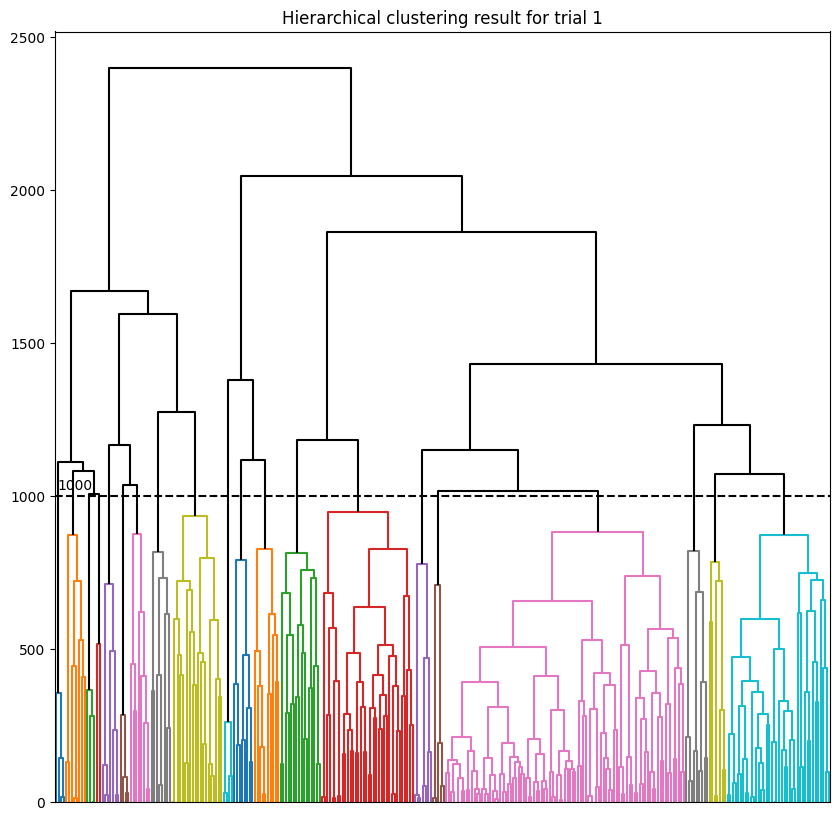

Number of clusters with the given cut distance:  20


<Figure size 640x480 with 0 Axes>

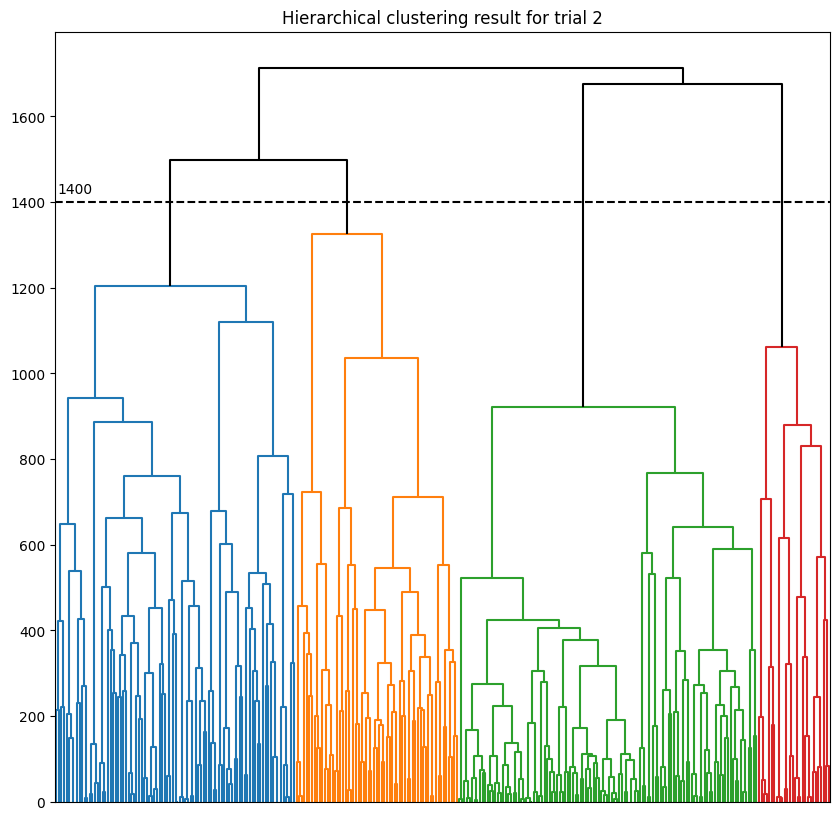

Number of clusters with the given cut distance:  4


<Figure size 640x480 with 0 Axes>

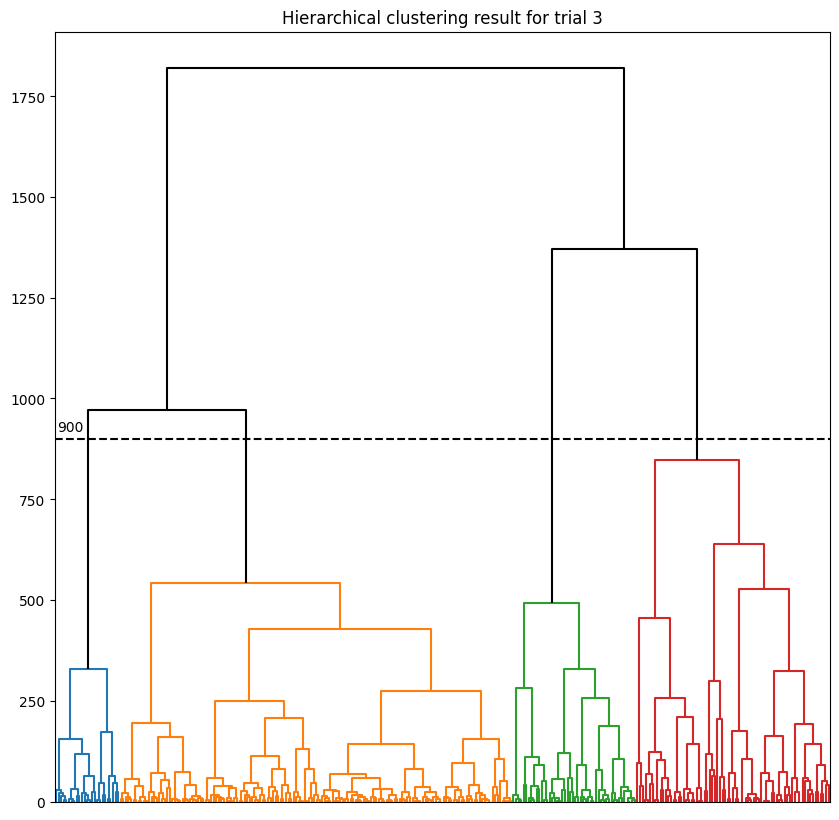

Number of clusters with the given cut distance:  4


<Figure size 640x480 with 0 Axes>

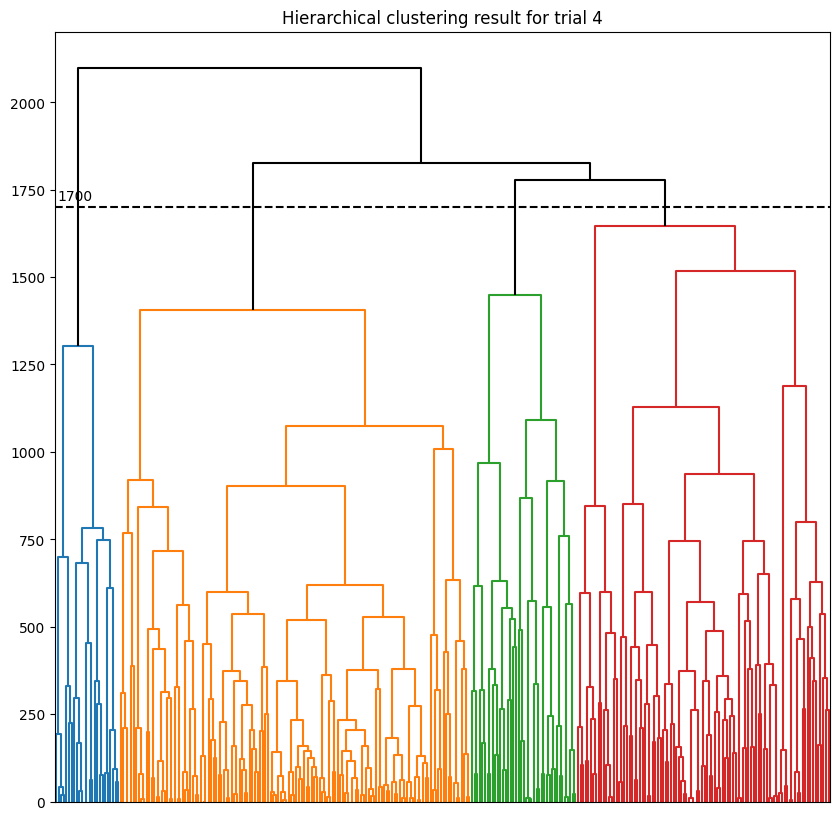

Number of clusters with the given cut distance:  4


<Figure size 640x480 with 0 Axes>

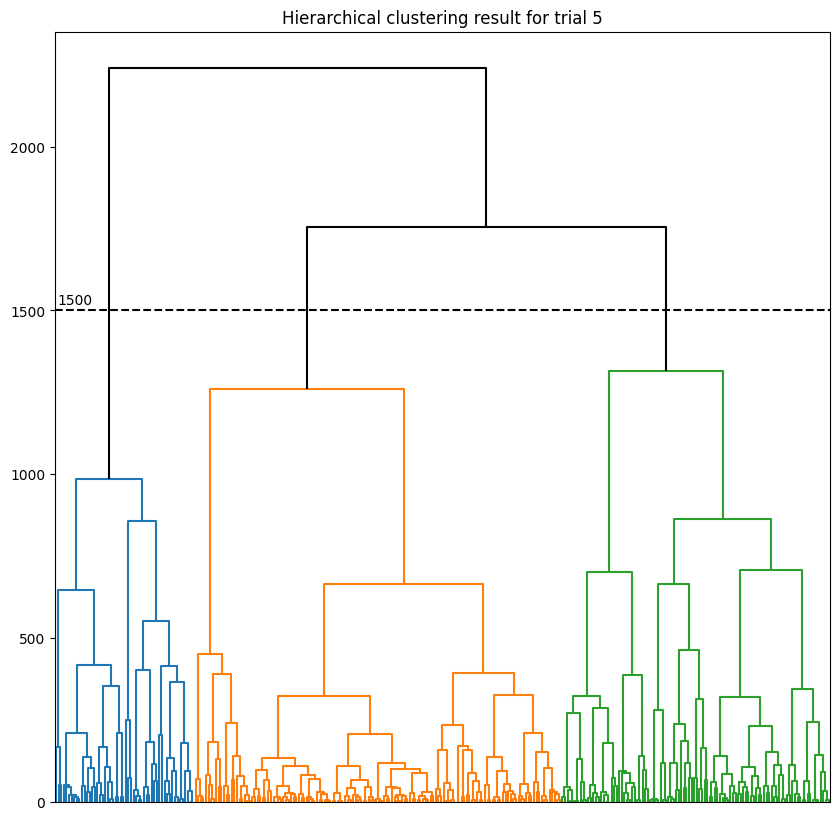

Number of clusters with the given cut distance:  3


<Figure size 640x480 with 0 Axes>

In [42]:
# - Load the dataset -------------------------------------------------------
dataset_dir = "dataset_vector_{}".format(key)
first = np.load("{}/{}_0.npy".format(dataset_dir, key))  # Load the first datapoint to retrieve the shape
data_shape = first.shape    # Shape for the whole dataset
print(data_shape)

time_stamps = np.load("time_stamps_{}.npy".format(key))
spec_indices = np.load("spectrogram_indices_{}.npy".format(key))

dataset = np.zeros((nb_samples, data_shape[0], data_shape[1]))  # Create the empty vector that will hold the full data
dataset[0] = first

for i in range(1, nb_samples):
    dataset[i] = np.load("{}/{}_{}.npy".format(dataset_dir, key, i))

dataset = dataset.reshape((nb_samples, data_shape[0], data_shape[1], 1))

autoencoder = Autoencoder(data_shape, latent_dim)
autoencoder.compile(optimizer="adam",
                    loss=losses.MeanSquaredError())
autoencoder.build((None, data_shape[0], data_shape[1], 1))

autoencoder.summary()

# - Compute Clustering -------------------------------------------------------
clusters = np.zeros((len(training_indices), nb_samples))

for i, index in enumerate(training_indices):
    autoencoder.load_weights("logs/training_{}/cp-00{}.ckpt".format(index, epoch_to_load))
    encoded_dataset = autoencoder.encoder(dataset)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    set_link_color_palette(colors)   # This sets the color of the dendrogram
    # NB: The dendogram function colors the clusters in merging distance order, which does not necessarily correspond to the order of the labeling of the clusters. For this reason, I chose to display the dendrogram in black and plot colours only on the density graph (below)

    def plot_dendrogram(model, cut_distance, **kwargs):
        # Create linkage matrix and then plot the dendrogram

        # create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for j, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[j] = current_count

        linkage_matrix = np.column_stack(
            [model.children_, model.distances_, counts]
        ).astype(float)

        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix, no_labels=True, color_threshold=cut_distance, above_threshold_color="black", **kwargs)

    agglo = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=cut_distance[i],
        linkage="ward",
        compute_distances=True
        )
    plt.figure(figsize=(10,10))
    agglo.fit(encoded_dataset)
    plot_dendrogram(agglo, cut_distance[i], truncate_mode=None)
    plt.axhline(y = cut_distance[i], color = 'black', linestyle = '--')
    plt.text(10, cut_distance[i]+20, "{}".format(cut_distance[i]))
    plt.title("Hierarchical clustering result for trial {}".format(i+1))
    plt.show()
    print("Number of clusters with the given cut distance: ", agglo.n_clusters_)
    clusters[i] = agglo.labels_
    #plt.savefig("clusters/dendrogram_{}_{}".format(key, i))

# K-means

In [43]:
n_clusters = 2  # Define the number of cluster to find

In [44]:
# - Compute K-means --------------------------------------------------------------------------------------
clusterings = np.zeros(nb_clusterings, dtype=object)

for i, index in enumerate(training_indices):
    autoencoder.load_weights("logs/training_{}/cp-00{}.ckpt".format(index, epoch_to_load))
    encoded_dataset = autoencoder.encoder(dataset)

    clusterings[i] = KMeans(n_clusters=n_clusters, init="k-means++", n_init=15).fit(encoded_dataset)

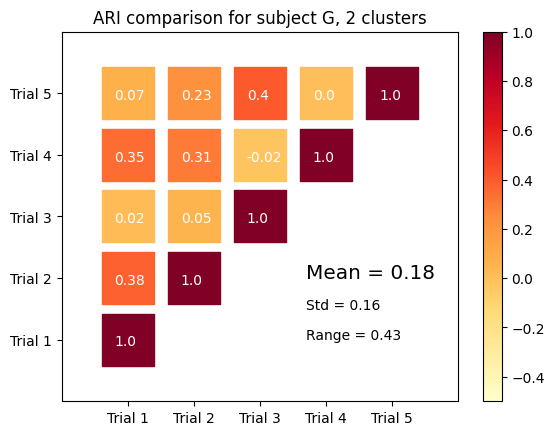

In [45]:
# - Plot the K-means trials ------------------------------------------------------------------------------
from sklearn.metrics.cluster import adjusted_rand_score
ARI_matrix = np.zeros(15)
center_distances = []
ARI_upper = []
x_coord = []
y_coord = []
z = 0

for i in range(nb_clusterings):
    distances_i = []
    for k in range(clusterings[i].cluster_centers_.shape[0]):   # Loop to compute inter-cluster distances
        for l in range(clusterings[i].cluster_centers_.shape[0]):
            if k<l:
                distances_i.append(np.sqrt(np.sum((clusterings[i].cluster_centers_[k]-clusterings[i].cluster_centers_[l])**2)))
    center_distances.append(distances_i)

    for j in range(nb_clusterings):                       # Loop to compute ARI scores
        if i<=j:
            score = adjusted_rand_score(clusterings[i].labels_, clusterings[j].labels_)
            ARI_matrix[z] = score
            x_coord.append(i)
            y_coord.append(j)
            plt.text(i-0.2, j-0.1, np.round(score, 2), c="white")
            z+=1
            if i!=j:
                ARI_upper.append(score)


plt.scatter(x_coord, y_coord, 1400, marker="s", c=ARI_matrix.flatten(), norm=plt.Normalize(-0.5,1) ,cmap="YlOrRd")
ticks = ["Trial {}".format(i+1) for i in range(nb_clusterings)]
plt.xticks(np.arange(5), ticks)
plt.yticks(np.arange(5), ticks)
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.colorbar()
mean_score = np.mean(ARI_upper)
std_score = np.std(ARI_upper)
plt.title("ARI comparison for subject {}, {} clusters".format(key, n_clusters))
plt.text(2.7,1,"Mean = {}".format(np.round(mean_score, 2)), fontsize="x-large")
plt.text(2.7,0.5,"Std = {}".format(np.round(std_score, 2)))
plt.text(2.7,0,"Range = {}".format(np.round(max(ARI_upper)-min(ARI_upper), 2)))
plt.show()

In [46]:
# - Inter-cluster distances ---------------------------------------
inter_cluster_mean = np.mean(center_distances)
inter_cluster_std = np.std(center_distances)

print("Mean : ", np.round(inter_cluster_mean, 0))
print("Std : ", np.round(inter_cluster_std, 0))
print("Range: ", np.round(max(center_distances)[0]-min(center_distances)[0],0))

# - Intra-cluster variance ----------------------------------------
# NB: We have no way of knowing the ordering of the clusters between trials, so intra-cluster variance has no meaning when averaged over all trials.
#mean_c_dist = np.zeros((nb_clusterings, n_clusters))
#std_c_dist = np.zeros((nb_clusterings, n_clusters))
#range_c_dist = np.zeros((nb_clusterings, n_clusters))
#for k in range(nb_clusterings):
#    for i in range(n_clusters):
#        labels_i = np.where(clusterings[k].labels_==i)[0]
#        labels_i = np.sqrt((encoded_dataset.numpy()[labels_i] - clusterings[k].cluster_centers_[i])**2)
#        mean_c_dist[k,i] = np.mean(labels_i)
#        std_c_dist[k,i] = np.std(labels_i)
#        range_c_dist[k,i] = labels_i.max() - labels_i.min()

Mean :  197.0
Std :  24.0
Range:  61.0


### Plot the clusters on the timeline
To select which clustering trial to plot, just change the index of the "agglo = clusterings[i]" line

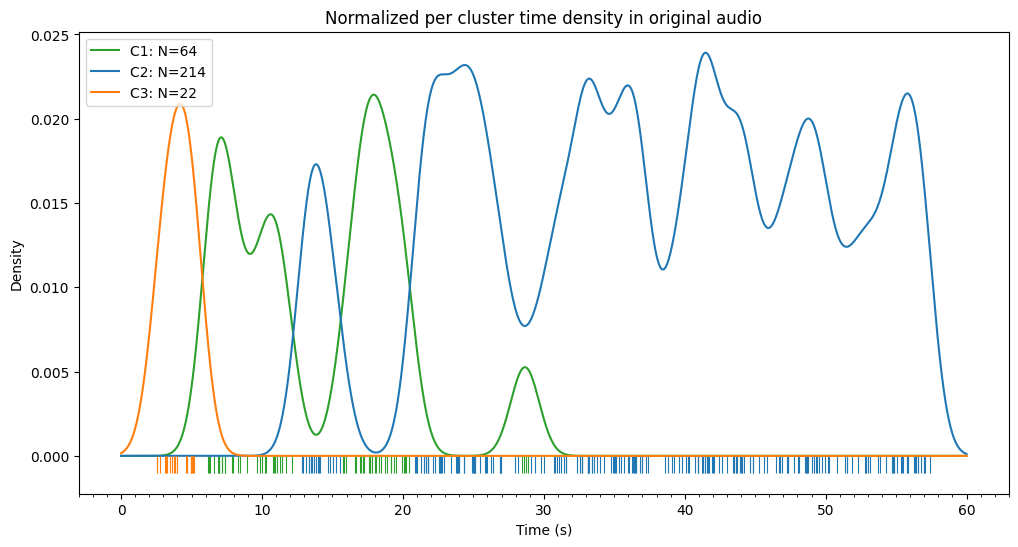

In [22]:
from sklearn.neighbors import KernelDensity
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
floor = np.linspace(0, 60, 100000)[:, np.newaxis]

colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
agglo = clusterings[0]
# Since the dendogram uses basic matplotlib colours, and uses the first one for the branches above, we need to skip a colour to have matching colours on the graph below and the dendogram.
fig, ax = plt.subplots(figsize=(12,6))
for i in range(3):
    cluster_samples = time_stamps[clusters[0]==i]+2.5
    kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(cluster_samples[:,np.newaxis])
    log_dens = kde.score_samples(floor)
    n_i = np.sum(clusters[0]==i)

    plt.plot(floor, (n_i/300)*np.exp(log_dens), label="C{}: N={}".format(i+1, n_i), color=colors[i])
    plt.vlines(cluster_samples, -1e-3, 0, linewidth=0.8, color=colors[i])
plt.title("Normalized per cluster time density in original audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Density")
ax.xaxis.set_minor_locator(MultipleLocator(1))